In [245]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## About bayesian statistics

- Applied A.I: http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/
- http://nbviewer.jupyter.org/github/aloctavodia/Doing_bayesian_data_analysis/blob/master/IPython/Kruschkes_Doing_Bayesian_Data_Analysis_in_PyMC3.ipynb
- pythonic preambulations: http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/
- mybridge

- http://fastml.com/bayesian-machine-learning/
- https://alexanderetz.com/understanding-bayes/
- Bayesian data analysis and cognitive modeling : http://www.sfs.uni-tuebingen.de/~mfranke/bda+cm2015/

## Mixture Density networks

- Bishop pattern recognition and machine learning: Mixture Density Networks page 272

## Generate data

- https://github.com/zer0n/deepframeworks/blob/master/README.md


#### about neural nets 
- http://www.demo.cs.brandeis.edu/pr/DIBA/
- evolutionary http://www.demo.cs.brandeis.edu/

- nnets cython: https://github.com/tburmeister/pyneural/tree/master/src


### How to make predictions with a bayesian model 
- https://www.youtube.com/watch?v=N4XpUocvz5E

### About dask
- https://jcrist.github.io/dask-sklearn-part-3.html

In [8]:
import generate_data
import matplotlib.pyplot as plt
import numpy as np
import theano 
import theano.tensor as T

X, Y = generate_data.generate_1dlinear_data()

## Learning the same data using a MLP
### variational.advi

In [9]:
X, Y = generate_data.generate_1dlinear_data()

In [10]:
X_train = X.reshape( (len(X),1))
Y_train = Y

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)

('X_train shape', (500, 1))
('Y_train shape', (500,))


In [34]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm

std_val = 0.5
n_hidden = 5
input_dim = 1
output_dim = 1

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, )
init_b2 = np.random.randn(output_dim )

mlp = pymc3.Model()

with mlp:
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_0_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_1', 0, sd=1, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden, ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_2', 0, sd=1, 
                           shape= (output_dim,), 
                           testval=init_b2)
    
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.dot(act_1, weights_1_out) + bias_in_2

    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal('Y_obs', mu=act_out, observed=ann_output)
    Y_obs = Normal('Y_obs', mu=act_out, sd=sigma, observed=ann_output)

Applied log-transform to sigma and added transformed sigma_log_ to model.


#### Train mlp using bayesian inference

In [35]:
with mlp:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mu_params, sds_params, elbo = pymc3.variational.advi(n=20000)
    step = pm.NUTS(scaling=mlp.dict_to_array(sds_params))
    #trace = pymc3.sample(2000, step, start=mu, progressbar=True)
    trace = pm.sample(100, step, start=mu_params, progressbar=True)

Iteration 0 [0%]: ELBO = -3895.41
Iteration 2000 [10%]: Average ELBO = -27963.23
Iteration 4000 [20%]: Average ELBO = -4266.68
Iteration 6000 [30%]: Average ELBO = -1759.79
Iteration 8000 [40%]: Average ELBO = -1279.39
Iteration 10000 [50%]: Average ELBO = -1151.16
Iteration 12000 [60%]: Average ELBO = -1057.8
Iteration 14000 [70%]: Average ELBO = -983.29
Iteration 16000 [80%]: Average ELBO = -913.85
Iteration 18000 [90%]: Average ELBO = -861.8
Finished [100%]: Average ELBO = -828.79
 [-----------------100%-----------------] 100 of 100 complete in 21.3 sec

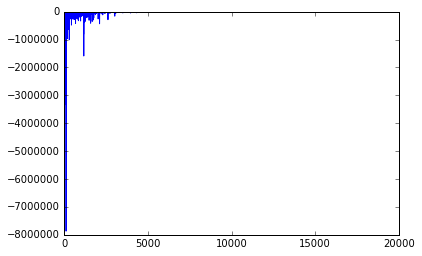

In [36]:
plt.plot(elbo)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4cdcb1250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc49a2ee850>]], dtype=object)

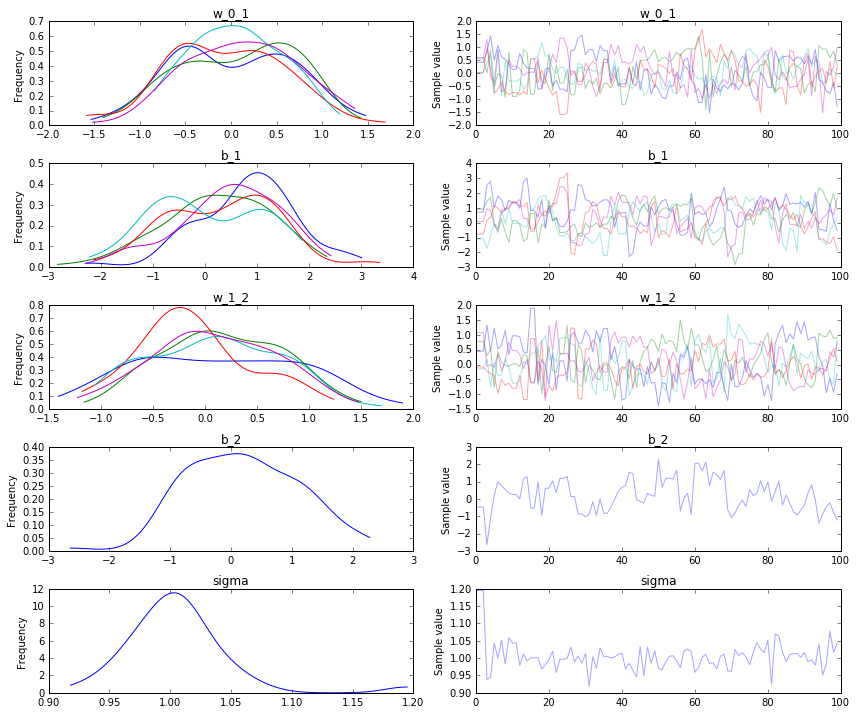

In [37]:
pm.traceplot(trace)

In [38]:
trace["w_0_1"].shape

(100, 1, 5)

In [39]:
trace["w_0_1"].mean(axis=0).shape

(1, 5)

In [40]:
trace["w_0_1"].mean(axis=0)

array([[ 0.02576559,  0.08127288, -0.06597365,  0.05529012,  0.11554295]])

In [41]:
###########################
# This should not be done #
###########################

X_train = X.reshape(len(X),1)
Y_train = Y

sym_input = T.dmatrix("sym_input")

# Defined shared variables of the model
sha_W1 = theano.shared(trace["w_0_1"].mean(axis=0))
sha_b1 = theano.shared(trace["b_1"].mean(axis=0))
sha_W2 = theano.shared(trace["w_1_2"].mean(axis=0))
sha_b2 = theano.shared(trace["b_2"].mean(axis=0))

act_1 = T.nnet.relu( T.dot(sym_input, sha_W1) + sha_b1)
act_out = T.dot(act_1, sha_W2) + sha_b2

In [42]:
predict = theano.function([sym_input],act_out)

In [43]:
x1_grid = np.linspace(-4, 4, 200)

x1_grid = np.array(x1_grid.reshape(len(x1_grid),1), dtype="float32" )

In [44]:
#predictions = predict(x1_grid)

### Making predictions

In [45]:
x1_grid = np.linspace(-4, 4, 200)

In [46]:
x1_grid = np.array(x1_grid.reshape(len(x1_grid),1), dtype="float32")

In [47]:
dummy_out = np.ones(x1_grid.shape[1], dtype=np.int8)

ann_input.set_value(x1_grid)
ann_output.set_value(dummy_out)

ppc = pm.sample_ppc(trace,
                    model=mlp, 
                    samples=2000)

In [48]:
predictions = ppc['Y_obs'].mean(axis=0)

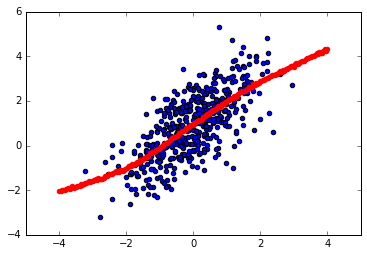

In [49]:
%matplotlib inline

## plot data
plt.scatter(X, Y)

# Write 
plt.scatter(x1_grid,
            predictions,
            color="r")

#### Plotting all models

For each mlp in the trace:
- get the parameters of the mlp 
- plot the predictions at each point in the grid.

In [50]:
sym_input = T.matrix("sym_input")

def model_prediction(X, w1, b1, w2, b2):

    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(X, w1) + b1)
    act_out = T.dot(act_1, w2) + b2
    
    return act_out.eval()

In [51]:
trace[0]

{'b_1': array([ 0.71310265,  0.90830802, -0.76252   , -1.08557108,  0.07209423]),
 'b_2': array([-0.45759189]),
 'sigma': 1.1948490009724098,
 'sigma_log_': 0.17801981838059666,
 'w_0_1': array([[ 0.4240934 ,  0.59755649,  0.02439653,  0.04515359,  0.59002876]]),
 'w_1_2': array([ 0.44409261,  0.78120994, -0.08435761, -0.14313305,  1.06906847])}

In [52]:
x1_grid = np.linspace(-4, 4, 200)
x1_grid = x1_grid.reshape((len(x1_grid),1))

x1_grid.shape

(200, 1)

In [53]:
k = 1
a = model_prediction(x1_grid,
                     trace["w_0_1"][k],
                     trace["b_1"][k],
                     trace["w_1_2"][k],
                     trace["b_2"][k])

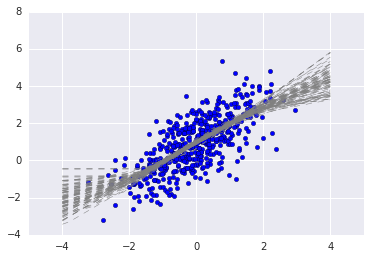

In [252]:
%matplotlib inline

## plot data
plt.scatter(X, Y)

num_models = len(trace)

for i in range(num_models):
    prediction = model_prediction(x1_grid,
                                  trace["w_0_1"][i],
                                  trace["b_1"][i],
                                  trace["w_1_2"][i],
                                  trace["b_2"][i])
    
    #import pdb;pdb.set_trace()
    plt.plot(x1_grid,
             prediction,
             color="grey",
             linestyle="--",
             linewidth=0.5)

### Computing the confidence of our predictions

Each element in trace has a "sigma" parameter

Make as many predictions as models in the trace, 

In [278]:
trace.varnames

['w_0_1', 'b_1', 'w_1_2', 'b_2', 'sigma_log_', 'sigma']

In [279]:
num_models = len(trace)
sigmas = []

for i in range(num_models):
    
    prediction = model_prediction(x1_grid,
                                  trace["w_0_1"][i],
                                  trace["b_1"][i],
                                  trace["w_1_2"][i],
                                  trace["b_2"][i])
    
    sigmas.append(trace["sigma"][i])

In [280]:
prediction.shape

(200,)

#### Given a feture assignment predict the target distribution

In [281]:
def gaussian(x, mu, var):
    return  (1./np.sqrt(2*np.pi*var)) * np.exp( -(x - mu)**2 /2*var)

In [282]:
gaussian(1,1,0.5)

0.56418958354775628

In [283]:
x1_grid[100], x1_grid[180]

(array([ 0.0201005]), array([ 3.2361809]))

In [284]:
def get_grid_centered_in_x(x, h, samples=200):
    return np.linspace(-x-h, x+h, samples)

In [313]:
a_from_grid = x1_grid[100]
b_from_grid = x1_grid[40]

In [314]:
a_from_grid, b_from_grid 

(array([ 0.0201005]), array([-2.3919598]))

#### a_from_grid

In [299]:
posterior_grid =  get_grid_centered_in_x(x=a_from_grid,
                                         h=4,
                                         samples=200)

In [300]:
posterior_grid.shape

(200,)

In [301]:
posteriors = []

for model_m in range(len(trace)):

    predict_x  = model_prediction(x_from_grid,
                                  trace["w_0_1"][model_m],
                                  trace["b_1"][model_m],
                                  trace["w_1_2"][model_m],
                                  trace["b_2"][model_m])
    variance = sigmas[model_m]

    posterior = []
    for x in posterior_grid:
        posterior.append(gaussian(x, mu=predict_x , var=variance ))
        
    posteriors.append(posterior)

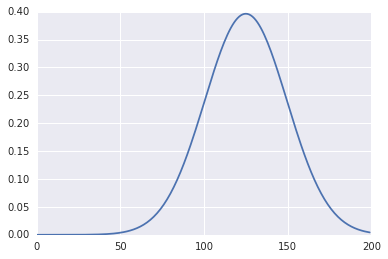

In [302]:
plt.plot(posteriors[40])

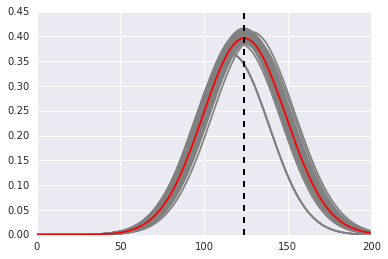

In [303]:
prob_t_given_x = np.mean(posteriors,axis=0)

for posterior in posteriors:
    plt.plot(posterior, color="grey")
    
plt.plot(prob_t_given_x, color="red")
plt.axvline(np.argmax(prob_t_given_x), 
            color="black", 
            linestyle='dashed',
            linewidth=2)

#### point b_from_grid

In [315]:
posterior_grid =  get_grid_centered_in_x(x=b_from_grid,
                                         h=4,
                                         samples=200)

In [316]:
x = x1_grid[0]

posteriors = []

for model_m in range(len(trace)):

    predict_x  = model_prediction(b_from_grid,
                                  trace["w_0_1"][model_m],
                                  trace["b_1"][model_m],
                                  trace["w_1_2"][model_m],
                                  trace["b_2"][model_m])
    variance = sigmas[model_m]

    posterior = []
    for x in posterior_grid:
        posterior.append(gaussian(x, mu=predict_x , var=variance ))
        
    posteriors.append(posterior)

KeyboardInterrupt: (None, <type 'set'>, ([(((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('205e8c81d5d71b386fbce04e0d9436d9', 0, 0), False)), (TensorType(float64, row), (('864907a0b9979f8ba28ea0d9acdfd110', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fa2df616af9d44370e2f3004684c1437', 0, 0), False)), (TensorType(float64, row), (('864907a0b9979f8ba28ea0d9acdfd110', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('188d8f8f678a14fd8f08a41a9aa7dae4', 0, 0), False)), (TensorType(float64, row), (('a0b41b194714481fb1f2a02337b2dae2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ad43c0560ac127dd257044b4e015bfbc', 0, 0), False)), (TensorType(float64, row), (('6e61d721c8a233011c71fc7fd81b96a8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('34f7759ace6683c845ada9b27694c753', 0, 0), False)), (TensorType(float64, row), (('a45de2143e73668f2d18b3891b8d5b29', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a612ef8e2bf9ac77c0c6ab59bae9a6d7', 0, 0), False)), (TensorType(float64, row), (('c748b5f698412a48e362a82ee87e41d0', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('837ddb6bac03e5e3d771385124c6ef59', 0, 0), False)), (TensorType(float64, row), (('6decf6379d674e6f7f3ccbb69feef7ba', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('ad43c0560ac127dd257044b4e015bfbc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('9c441b606afa85bc766cd622c369ddba', 0, 0), False)), (TensorType(float64, row), (('1991b9e6220920fe892ff90ff416e167', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ca7320471208831cd9365daf7a4501e6', 0, 0), False)), (TensorType(float64, row), (('9058d262f42f63c22a0a9e009605b050', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aad66b64e168c875e07ce3727d909d98', 0, 0), False)), (TensorType(float64, row), (('4fe31b1124486effd1ff81c200a86783', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('17550b115456e593b02e0be81fc1dc5e', 0, 0), False)), (TensorType(float64, row), (('ef7d9ca524476746191bba135149186e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5ecfca24f3872e1884a8940584394188', 0, 0), False)), (TensorType(float64, row), (('51e4a186a2f5e02fc8cf0b64649f9f5c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fd263f84c18c9c88f1dec8b98c755000', 0, 0), False)), (TensorType(float64, row), (('0ebc1853e8539a1e686796619238dd74', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2a8ec138d8c27af5eef3ba5f11ddd14e', 0, 0), False)), (TensorType(float64, row), (('a81e94ec756ba546cc0dfdd0ba4d0f3e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('3934b571e768b4719014fd5801f348a4', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('6e89d73028c3b99113a6df2ff5cec966', 0, 0), False)), (TensorType(float64, row), (('e6d73b52b57db0c3e16a76f00b95ce98', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('086f770af8c7b85e4e4d2819bdad01df', 0, 0), False)), (TensorType(float64, row), (('ee0955f3d52a22118059a91350ce979d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7f1a788847ef2ce5afb2732c76f56795', 0, 0), False)), (TensorType(float64, row), (('add899cbf8b6e2449daaf1c2b3d4fd3c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c7acdedcac8e3d1ecd36803c9d58fe10', 0, 0), False)), (TensorType(float64, row), (('728980d221cd2de73c30a59f4e4a3a5b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('17550b115456e593b02e0be81fc1dc5e', 0, 0), False)), (TensorType(float64, row), (('5b1850897108a6e97e20abc4d1fdcf30', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f8a617bce921ca8df76bb3ef99eba570', 0, 0), False)), (TensorType(float64, row), (('b28a7c05e54f3eaade80b088d349c96a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('6a03da4eb06f05e6028dd70fdd2602e9', 0, 0), False)), (TensorType(float64, row), (('141ccf4242f1759a39629da214defc82', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('8110d57a3278f22d4f42c0cd23d27c53', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e96b02721e2c485f9deda9cae1796f15', 0, 0), False)), (TensorType(float64, row), (('a73809bba8d3d4acccecf202f4ce1d16', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('67e44188f2ee48278b948d56fea74a35', 0, 0), False)), (TensorType(float64, row), (('1cc2c4df55c5997f48390b38d1775c8b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('71377dbec18187428f3ad1dd97ca3731', 0, 0), False)), (TensorType(float64, row), (('e6d73b52b57db0c3e16a76f00b95ce98', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('beb9b667fd4b2ab00e2b50336ac5ef7b', 0, 0), False)), (TensorType(float64, row), (('ecb5fb7ff6954040ea509906096b552d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aca8951ec2eba8d864bcb0d068d24cd7', 0, 0), False)), (TensorType(float64, row), (('243d3326af6a3803ae02c7188fbbf84d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('615ac1f17593915b8ecbe61052291e04', 0, 0), False)), (TensorType(float64, row), (('db419e3c88795dbb1dd354586e3813b4', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('387688b2fa336561a25d1317533b6bf0', 0, 0), False)), (TensorType(float64, row), (('1991b9e6220920fe892ff90ff416e167', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8110d57a3278f22d4f42c0cd23d27c53', 0, 0), False)), (TensorType(float64, row), (('4ee0da49ce8fa7be10d5a32ba6399a83', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('324f397f7e991b5eefe4eebf8f5e6374', 0, 0), False)), (TensorType(float64, row), (('5327a6774793daaf0916a075e8fc6707', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('141ccf4242f1759a39629da214defc82', 0, 0), False)), (TensorType(float64, row), (('339d24d17e7523f5a971c920967675b9', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('005878805315a3c109318a7846d410a5', 0, 0), False)), (TensorType(float64, row), (('7a2af7dffa348fc8a7054b46a75bef42', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f2cd5b4b8702d022267490d2179c8051', 0, 0), False)), (TensorType(float64, row), (('5f8794b5c91c886f77739325741a2338', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('73fd281e54604164a9e98e4511d47d38', 0, 0), False)), (TensorType(float64, row), (('ed5e0f303baae7dd8304f11f0c011778', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('49236f6af9da9cdb44b4b6099817ecef', 0, 0), False)), (TensorType(float64, row), (('3d3d649c192d94f36041d55f99dda00b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('39e01a87779e32b20bfebdb39eb11a54', 0, 0), False)), (TensorType(float64, row), (('46c7b07caf63c04bdf5b281e9034e87a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e7e1ce4f4e9e2df64b2e421af7d3d549', 0, 0), False)), (TensorType(float64, row), (('24d15a5292f83bd40fcd853110012f5f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a73809bba8d3d4acccecf202f4ce1d16', 0, 0), False)), (TensorType(float64, row), (('023d60d8149590e6cf2fb783fb98f199', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('966daf6a2db6fb529e881fd5f2e1ce55', 0, 0), False)), (TensorType(float64, row), (('0058cd24c9b483c2275da610a485bfdd', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c14cdb905096e2932ceba022f6d30a8f', 0, 0), False)), (TensorType(float64, row), (('4e75587d879132cb3c89c7aeee8ece81', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('cc4b8b09dc52d091764321c7def36ab7', 0, 0), False)), (TensorType(float64, row), (('1f9442961a620c7a96c7161e2b259f28', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('38202a0a1f75836d2d8b32e50930b10a', 0, 0), False)), (TensorType(float64, row), (('98c0875b5d77dff4c8ddaf9c5e1b029a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aca8951ec2eba8d864bcb0d068d24cd7', 0, 0), False)), (TensorType(float64, row), (('59c90bbde95f2c401f098471cb8feb59', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('90cee1a0e021946e08b68f4de3e3a9c6', 0, 0), False)), (TensorType(float64, row), (('ee8d099cc12efb17d13f283be73b0de2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('72125a694fcb44811bfdfb9513a5de87', 0, 0), False)), (TensorType(float64, row), (('72125a694fcb44811bfdfb9513a5de87', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4f7f54456fd22de38ac57f6f5f34c0a2', 0, 0), False)), (TensorType(float64, row), (('98d1b8363ca80eb59dc76722ace7fbde', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e919f5eb005ce60069e65b9a91968fbb', 0, 0), False)), (TensorType(float64, row), (('32f93c1942c1304654a74bce374130ea', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c28d70df86d2b1a567d3ae2832f6eba2', 0, 0), False)), (TensorType(float64, row), (('e1e53c9239062672dc88694d3b995d75', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fcc8c0fecc04ccdf1e2c12ff39c127b1', 0, 0), False)), (TensorType(float64, row), (('b94dd8c0993ef62319303ebb7576ccd6', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aca8951ec2eba8d864bcb0d068d24cd7', 0, 0), False)), (TensorType(float64, row), (('79d4226eafd8e9237ed2d9763846eb15', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('10e593c9e002047aa1badb39d68b76a6', 0, 0), False)), (TensorType(float64, row), (('615ac1f17593915b8ecbe61052291e04', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4d976c68b98ca35ce6fa53ddc0a0d1c7', 0, 0), False)), (TensorType(float64, row), (('cb9e7a4bc9718b7af61cca0439d624bb', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d74979d3baad5097b3ed6b51acdaae2f', 0, 0), False)), (TensorType(float64, row), (('b3e22d7caa0cbd1d4153c218acd30482', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0cf2f49f607f272c661dfc0ae906bb02', 0, 0), False)), (TensorType(float64, row), (('ea1c4d4b15009c7743dd1ce7583d3561', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('674a83d8dc75444322f5bae400385426', 0, 0), False)), (TensorType(float64, row), (('0b47ae950e2568e34a44ef34b5eef3b6', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e41860562caf5585258b5e8bf2fad53b', 0, 0), False)), (TensorType(float64, row), (('aad6fb07d4f879e8158ff22dfd4aac75', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('374187e1ed312c1d2384cb903c3f993b', 0, 0), False)), (TensorType(float64, row), (('5bf5f14a27a45f69c17847617d0093bc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1fcf5ca2495efcc1c8ea93d823712655', 0, 0), False)), (TensorType(float64, row), (('c28d70df86d2b1a567d3ae2832f6eba2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a74b051fc50537b04f1bb62f944aa5a9', 0, 0), False)), (TensorType(float64, row), (('4bb4f6a0f19aebd08d8576ff493bcfd3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('75d8f6c826537f4b25180a698bf1c2af', 0, 0), False)), (TensorType(float64, row), (('09d6a9ec3247ccc97a0b11e65d49b1b5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c392935d89b4015066e8e27af7de1fa0', 0, 0), False)), (TensorType(float64, row), (('3bfa887545a31432a9587b86f8e5edbf', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2f42f983e98d6947335d6fc8c760491f', 0, 0), False)), (TensorType(float64, row), (('8d43e8e27d58c5a9670eed97697be351', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('14d0d06f2c0ddfd513d413a8b268a4a6', 0, 0), False)), (TensorType(float64, row), (('69bbe2912513e735dce1a837a15495db', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1991b9e6220920fe892ff90ff416e167', 0, 0), False)), (TensorType(float64, row), (('45c58cb8f6c15132544bfaa579848183', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b28a7c05e54f3eaade80b088d349c96a', 0, 0), False)), (TensorType(float64, row), (('895b7afe19a97676675568de44843194', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('782f9e9a13b9b75776020b6791b8e4f1', 0, 0), False)), (TensorType(float64, row), (('298c20778405a8bd0e7c9ea4849afc97', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fb8116c908ddc4c98de2e0cc64bc12d0', 0, 0), False)), (TensorType(float64, row), (('c28d70df86d2b1a567d3ae2832f6eba2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('528097b190b977d7aaf41ba68648a77b', 0, 0), False)), (TensorType(float64, row), (('d5a6f39bb8d7dd26ea43a3ebd5bafc77', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('497074b62e19540ba3222deabced89a2', 0, 0), False)), (TensorType(float64, row), (('582a55d9cec114d863122323738f82d7', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('582a55d9cec114d863122323738f82d7', 0, 0), False)), (TensorType(float64, row), (('4bb699dfa30c4c4b2dd48565ec5dbcaa', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('79d4226eafd8e9237ed2d9763846eb15', 0, 0), False)), (TensorType(float64, row), (('9322fdfd9d9dd1750222cfb28f8c0a2a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('26db1757c9bad1fd26f7497a13289190', 0, 0), False)), (TensorType(float64, row), (('b7f2b5fddf3a5e7a41b0146c8386c1f6', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f61a2491c68667125e8d6b6b5c0aac36', 0, 0), False)), (TensorType(float64, row), (('7b67ab365d950fd95a88f1b7746fa3ba', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('eaedd95225d9c8e72f43a05786eb9df7', 0, 0), False)), (TensorType(float64, row), (('b2e72ae5037f62121c1f274117dbf2bc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('842c7ad29cc824b82b5a1fcfb231b353', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3c687da2dae72ffbfbdd29f92c229fbe', 0, 0), False)), (TensorType(float64, row), (('4fe31b1124486effd1ff81c200a86783', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b97d1ffc6d86274ef1c7ca31ef0e88f1', 0, 0), False)), (TensorType(float64, row), (('d2740869498fadbd5568b15be71cdc57', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fecdb5228c5fd2e979fbb62e0188e3dd', 0, 0), False)), (TensorType(float64, row), (('fcc8c0fecc04ccdf1e2c12ff39c127b1', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('16a43e41d76cb7123bb2a26fe8046a19', 0, 0), False)), (TensorType(float64, row), (('89b312b256f51a707cc80f5323ab1309', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2a39b9a076fae91f2ebb41e9014b3605', 0, 0), False)), (TensorType(float64, row), (('46c7b07caf63c04bdf5b281e9034e87a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('941196e616e29c24a814c4fea23f6a3e', 0, 0), False)), (TensorType(float64, row), (('f7bd3446f621cb627253d5f5b1c10730', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f655652f26daf43503fc7b8017ee3d9f', 0, 0), False)), (TensorType(float64, row), (('e4d07b03436b07fc495bbbf1f4e9ce3a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4d976c68b98ca35ce6fa53ddc0a0d1c7', 0, 0), False)), (TensorType(float64, row), (('005878805315a3c109318a7846d410a5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1302f53e29ac13778058372ec9642b8b', 0, 0), False)), (TensorType(float64, row), (('1302f53e29ac13778058372ec9642b8b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ef29401cc1cff17fc8ba7bbf2c85f4db', 0, 0), False)), (TensorType(float64, row), (('12492403f731380893c1919727edf87e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a1412d92b697913bbc5bc248bfe4fae1', 0, 0), False)), (TensorType(float64, row), (('dc9c55768a3d630ecbcc1208f4a13438', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c7673ca46560fd4343cb11bceb60f473', 0, 0), False)), (TensorType(float64, row), (('26db1757c9bad1fd26f7497a13289190', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3a343967e6afd1580785af504dc96b9c', 0, 0), False)), (TensorType(float64, row), (('3996722344618b488351c50e973243ec', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fd65e7df3396fe6dab243add0b982cb8', 0, 0), False)), (TensorType(float64, row), (('3a343967e6afd1580785af504dc96b9c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('73ec99fcd102034ab0e0e71a3b1c24b0', 0, 0), False)), (TensorType(float64, row), (('04f66dd31f8e2d1174e3c637c2ac2504', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5f8794b5c91c886f77739325741a2338', 0, 0), False)), (TensorType(float64, row), (('39e285e4faef5780c6dfa7168e6b92d4', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e3d0ed95b03d2b05c9dde2b326a46cda', 0, 0), False)), (TensorType(float64, row), (('26db1757c9bad1fd26f7497a13289190', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c74595887d5121d7ccb74b7c936c6f5b', 0, 0), False)), (TensorType(float64, row), (('f53ccb8317b10d39ef67060c792b4e75', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a3832d7d40c047eae104cd4240696e79', 0, 0), False)), (TensorType(float64, row), (('61fad23c76a4679eaf25b1965ad793df', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8d97458244fe711797bd688921d3a373', 0, 0), False)), (TensorType(float64, row), (('ea1c4d4b15009c7743dd1ce7583d3561', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d3365a46a8761d74c1ae1f5462f910fe', 0, 0), False)), (TensorType(float64, row), (('f655652f26daf43503fc7b8017ee3d9f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('07c249c6b3b684fa795a3d4a2a082ddc', 0, 0), False)), (TensorType(float64, row), (('2f5e6ee8e5d5cbf830dab40ee52d4c93', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f3604c0bb84a7e34938ccdc636c69d3e', 0, 0), False)), (TensorType(float64, row), (('669edb8851dc8be4d2f8f3a6da30025a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('34a2d1028558fdbe3b5522a7b97f851b', 0, 0), False)), (TensorType(float64, row), (('127614ed59d0f6a116ab1cab02f6af25', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c7673ca46560fd4343cb11bceb60f473', 0, 0), False)), (TensorType(float64, row), (('20e7683707b47d969f2e4b3413e385d5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('baefee64da96c05ac1d59ae7fc14acd5', 0, 0), False)), (TensorType(float64, row), (('b97d1ffc6d86274ef1c7ca31ef0e88f1', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e8a9736bffe17db8fd383375424db9b9', 0, 0), False)), (TensorType(float64, row), (('c2300c268bd255ae02eaf75c2697dbd8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('10c5e3755aba40515304ddcf291e3242', 0, 0), False)), (TensorType(float64, row), (('2abce56693b56da86648a0097c99df4b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('19f7d8076b5411376659f1fa099c34e2', 0, 0), False)), (TensorType(float64, row), (('005878805315a3c109318a7846d410a5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7520c6918cc2e10b51a6dc2817f8610a', 0, 0), False)), (TensorType(float64, row), (('b51e1c84e3c2a1fe17a28d519955d7a6', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ac43c8b2fdec571e982ea7b77b81c913', 0, 0), False)), (TensorType(float64, row), (('03c08c1142d752d542b6834a475c3cc8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5302f4f9834aea772b268daac0da6658', 0, 0), False)), (TensorType(float64, row), (('9495b854f60f26a2436827096fd5ee26', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0295ee28ac33344341783c01330296f0', 0, 0), False)), (TensorType(float64, row), (('9b8df5fa781b742b51a85b66ceae9d60', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a5c4d51c9669c74e5778f4f2c8485eda', 0, 0), False)), (TensorType(float64, row), (('3934b571e768b4719014fd5801f348a4', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d2edf6a754fbbe16a658e257ab484d12', 0, 0), False)), (TensorType(float64, row), (('79d4226eafd8e9237ed2d9763846eb15', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f1ce50ab4afa213e84dc863f7b7eba62', 0, 0), False)), (TensorType(float64, row), (('5a65231551acab98abb0d1792b03257f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('394a41c35581a2718ddba4312293906d', 0, 0), False)), (TensorType(float64, row), (('8fcd777bead333169150e3c0184715e5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0b3f05e82a9faa3f51aa4dcb3fd6979b', 0, 0), False)), (TensorType(float64, row), (('75d8f6c826537f4b25180a698bf1c2af', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e96b02721e2c485f9deda9cae1796f15', 0, 0), False)), (TensorType(float64, row), (('4e75587d879132cb3c89c7aeee8ece81', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fdde1f44036840b0837b9e41822c30b8', 0, 0), False)), (TensorType(float64, row), (('a562d439e930b61a47b24e5273f6caec', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('250843ca8418d70b7e6e201835e257c5', 0, 0), False)), (TensorType(float64, row), (('510a9c5c3a39c4e44bd35c4cdacb1f27', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0a6399e28b9bc479feb32e83dc47b0cf', 0, 0), False)), (TensorType(float64, row), (('20e7683707b47d969f2e4b3413e385d5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('982a00cdff7489da8f150951053a714a', 0, 0), False)), (TensorType(float64, row), (('65289e51fe1711b41450fa09a5109a8d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b2e97e2f6ff80b55e732a68ccd9ead8e', 0, 0), False)), (TensorType(float64, row), (('e3d6e14e8d7c34e326a89d1d01297532', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2bdff790ea4d93f2f85d2473e5b49c48', 0, 0), False)), (TensorType(float64, row), (('5f8794b5c91c886f77739325741a2338', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d3763cfe807001bd8be87c3adee81995', 0, 0), False)), (TensorType(float64, row), (('71c640e072241d720e98bb55090b9cdd', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('69cfe074db6da503847915486ce228f5', 0, 0), False)), (TensorType(float64, row), (('981fb0e314c75ac168e92ae2de994a5b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5626a8104160d131dcebf225cb436fdb', 0, 0), False)), (TensorType(float64, row), (('615ac1f17593915b8ecbe61052291e04', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('809b596c77f036a1f655e15d916c58d9', 0, 0), False)), (TensorType(float64, row), (('71ab017d2f15a71e1b85911b6b6d4467', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('636787079d80a678e517d61efd4519aa', 0, 0), False)), (TensorType(float64, row), (('53e36f0e91be4ea607a2e8ea4812b08e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('9f07a3e0d9a8ca96484b9f95be943c29', 0, 0), False)), (TensorType(float64, row), (('674a83d8dc75444322f5bae400385426', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('966daf6a2db6fb529e881fd5f2e1ce55', 0, 0), False)), (TensorType(float64, row), (('b2e97e2f6ff80b55e732a68ccd9ead8e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c4e1ab13c23e050a2e046c7e2f46272a', 0, 0), False)), (TensorType(float64, row), (('1c3fca79ed3e6c6ec30479ecd6e49a64', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('57d0677aa14d1c8a1fac8f2cf70c76ff', 0, 0), False)), (TensorType(float64, row), (('add899cbf8b6e2449daaf1c2b3d4fd3c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fd263f84c18c9c88f1dec8b98c755000', 0, 0), False)), (TensorType(float64, row), (('20553e5a543f093d0a30e80effb69736', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fb8116c908ddc4c98de2e0cc64bc12d0', 0, 0), False)), (TensorType(float64, row), (('9979001fc42c9eb50ed7dd019f381883', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5bab61faed1c5f55126485c9ae443e01', 0, 0), False)), (TensorType(float64, row), (('a42db2b808aba8d7f394627252b7068c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('909c61acc0228b42fa29947bbc2650d3', 0, 0), False)), (TensorType(float64, row), (('15e830879564327f65b0b0c26496513d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7f16e366e6e25624b664835cc2d7b132', 0, 0), False)), (TensorType(float64, row), (('d411d26a9683f5704acb0babbdde781c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('53ecc58b24aeb4f6a4ab37c60e7f38f8', 0, 0), False)), (TensorType(float64, row), (('3eea76e6652dfe1472984a3cf51a193e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('891e43e17761d67d7043b350a05e8428', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d3365a46a8761d74c1ae1f5462f910fe', 0, 0), False)), (TensorType(float64, row), (('35204c3c0e8ef825dbd04fbf53d1bbe3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3bfa887545a31432a9587b86f8e5edbf', 0, 0), False)), (TensorType(float64, row), (('3bfa887545a31432a9587b86f8e5edbf', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('9987cd8141964d8db155748de950d308', 0, 0), False)), (TensorType(float64, row), (('4fe31b1124486effd1ff81c200a86783', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('52b341717255459391c1a97a71aace3d', 0, 0), False)), (TensorType(float64, row), (('e4a7ecdf7d9593e4567b04992d798cb0', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('91c9bf7b88b7761b777149bca0df0756', 0, 0), False)), (TensorType(float64, row), (('b64d8474f39268cdbba3f1e8ddc4f124', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7b3bdf4a3715c65f24918dfd7d7fda94', 0, 0), False)), (TensorType(float64, row), (('3d2cc073fb8b7c35058a6140c6319ac7', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('eb8289bfb9d6d3e33cae5055b8933c05', 0, 0), False)), (TensorType(float64, row), (('aa8767c7b0067e692cd43376f903dc6a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4fa22d84c7b051c5b7fe3132f200469b', 0, 0), False)), (TensorType(float64, row), (('d0467076c24180bc8f7fca311af0afc2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ff3410>, ((TensorType(float64, row), ((-1, 0), False)), (TensorType(float64, row), ((-1, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3e18ae6c865d0d6f371acb3f5860eeb5', 0, 0), False)), (TensorType(float64, row), (('402892f1a5e848f1f1eb0e91678099a2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e8a96d6b3bb5aa540c72cf94593853d2', 0, 0), False)), (TensorType(float64, row), (('e257d05d22068ca8891516d36438aed7', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('583846510b5665d1db6ad1b3224222b7', 0, 0), False)), (TensorType(float64, row), (('9bbcce636fab626de323d53559270ad0', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8d1221282712d0decb61ba194d409da5', 0, 0), False)), (TensorType(float64, row), (('8d1221282712d0decb61ba194d409da5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fecdb5228c5fd2e979fbb62e0188e3dd', 0, 0), False)), (TensorType(float64, row), (('ecb5fb7ff6954040ea509906096b552d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7cb288dd0d3c35d067b68bd7357d6a8d', 0, 0), False)), (TensorType(float64, row), (('35204c3c0e8ef825dbd04fbf53d1bbe3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ff19fa1e242d2748a211bd26f6037dba', 0, 0), False)), (TensorType(float64, row), (('0295ee28ac33344341783c01330296f0', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('87ed3f6db763e57a8396379972c7c854', 0, 0), False)), (TensorType(float64, row), (('e9ec768474644f287a5d1ff29fbe5f77', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('34f298f4b4e5f8565d4968eac05585ff', 0, 0), False)), (TensorType(float64, row), (('a562f72b649cc81b95b8698866dfa555', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ece0e9ffb7da9fe51e78696ecfe547a2', 0, 0), False)), (TensorType(float64, row), (('8110d57a3278f22d4f42c0cd23d27c53', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fd3ab9888b3aab45cad17eab95e33b3c', 0, 0), False)), (TensorType(float64, row), (('77410555aec575fd9544b661c0c2a673', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3c9771ca64e66393bc5da2bd51a789e0', 0, 0), False)), (TensorType(float64, row), (('b2e97e2f6ff80b55e732a68ccd9ead8e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4e75587d879132cb3c89c7aeee8ece81', 0, 0), False)), (TensorType(float64, row), (('6f2a8ceeb8664452bd3183412c3e6f07', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a2bac2d5a172cb5e65e3c617a16dbe76', 0, 0), False)), (TensorType(float64, row), (('6ad35fa73733e571e99fcbcd1015e1bf', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8711d5f830d815a90895e696a621c54c', 0, 0), False)), (TensorType(float64, row), (('8711d5f830d815a90895e696a621c54c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0058cd24c9b483c2275da610a485bfdd', 0, 0), False)), (TensorType(float64, row), (('1eb5c41a41302e53bbe04d30c5a84cfd', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d21a325abad21df3d678c764cba47b5b', 0, 0), False)), (TensorType(float64, row), (('91c9bf7b88b7761b777149bca0df0756', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5f13911e687b909444f1677d942f1529', 0, 0), False)), (TensorType(float64, row), (('2abce56693b56da86648a0097c99df4b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('863f9417d45d3cf3282a4b2c78ee0d79', 0, 0), False)), (TensorType(float64, row), (('88675c2c280f315b6f40f2251bc3bbf9', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('34f298f4b4e5f8565d4968eac05585ff', 0, 0), False)), (TensorType(float64, row), (('d984c86efb7846a838845ac332d75304', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('21a3e41a85a41a26f9cfba27bf1bec79', 0, 0), False)), (TensorType(float64, row), (('71ab017d2f15a71e1b85911b6b6d4467', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b2c97e4e19a8e1e1cf8493fae45edc72', 0, 0), False)), (TensorType(float64, row), (('842c7ad29cc824b82b5a1fcfb231b353', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2abce56693b56da86648a0097c99df4b', 0, 0), False)), (TensorType(float64, row), (('5ec903936f3a8da8763f7089ad1613fe', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4d976c68b98ca35ce6fa53ddc0a0d1c7', 0, 0), False)), (TensorType(float64, row), (('141ccf4242f1759a39629da214defc82', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d085f24f14362c49cb2fc7c40733b1e8', 0, 0), False)), (TensorType(float64, row), (('71b9b590fced61cde229154221732050', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d21a325abad21df3d678c764cba47b5b', 0, 0), False)), (TensorType(float64, row), (('77410555aec575fd9544b661c0c2a673', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a89b5271020238fe63b7c2ad063b7219', 0, 0), False)), (TensorType(float64, row), (('e8a96d6b3bb5aa540c72cf94593853d2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8aa98ab3fcbabd7b250513bd462131b1', 0, 0), False)), (TensorType(float64, row), (('150c6164cc94f82b05e5595939177a2e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d5a6f39bb8d7dd26ea43a3ebd5bafc77', 0, 0), False)), (TensorType(float64, row), (('d2cdc048dc34ebdd6a5629a0637e19ad', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('eb8289bfb9d6d3e33cae5055b8933c05', 0, 0), False)), (TensorType(float64, row), (('582a55d9cec114d863122323738f82d7', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('63822ac48b6aaa9a3038315213f0de56', 0, 0), False)), (TensorType(float64, row), (('8da71df02a7630c065a89469c846bad2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8d43e8e27d58c5a9670eed97697be351', 0, 0), False)), (TensorType(float64, row), (('edcbc39ddd90f322fae7a6525508435c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ac43c8b2fdec571e982ea7b77b81c913', 0, 0), False)), (TensorType(float64, row), (('d5a6f39bb8d7dd26ea43a3ebd5bafc77', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('34f298f4b4e5f8565d4968eac05585ff', 0, 0), False)), (TensorType(float64, row), (('fdde1f44036840b0837b9e41822c30b8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('290df66a08b6c0b94e57105b929887fd', 0, 0), False)), (TensorType(float64, row), (('07c249c6b3b684fa795a3d4a2a082ddc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7c945878a31cd4c9cf049b7a433e631c', 0, 0), False)), (TensorType(float64, row), (('d28ab52a91793c8bd6ba15363aad3d2b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('9987cd8141964d8db155748de950d308', 0, 0), False)), (TensorType(float64, row), (('c7acdedcac8e3d1ecd36803c9d58fe10', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b31b6e5db2708bc1b673da6d28ac6024', 0, 0), False)), (TensorType(float64, row), (('be01a0818769d798d931df5b73a415d2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2cbc9e9be029779fbd1a4982ce670f50', 0, 0), False)), (TensorType(float64, row), (('aa8767c7b0067e692cd43376f903dc6a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ac72400976ef9cc9837b2436ee3f3cf4', 0, 0), False)), (TensorType(float64, row), (('0726280f73c257dc5db9fac9c86916be', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e499c699a3c5a7ecd6ce5667d3eec6e7', 0, 0), False)), (TensorType(float64, row), (('bd4015923d4c24fb5e1ada2fc9abaab9', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0896f76d5ed5e2184f42161c189d2802', 0, 0), False)), (TensorType(float64, row), (('9979001fc42c9eb50ed7dd019f381883', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('34f298f4b4e5f8565d4968eac05585ff', 0, 0), False)), (TensorType(float64, row), (('0295ee28ac33344341783c01330296f0', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('66e18daa73d7eafc95002ed9e02a4b2d', 0, 0), False)), (TensorType(float64, row), (('e69d52fd9d6659e040ae51896854118d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ac43c8b2fdec571e982ea7b77b81c913', 0, 0), False)), (TensorType(float64, row), (('b28a7c05e54f3eaade80b088d349c96a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b9a21adbe33d5c615db3b7a1685e5d60', 0, 0), False)), (TensorType(float64, row), (('c8750e44e6b5915e8744e79b4108858f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d3365a46a8761d74c1ae1f5462f910fe', 0, 0), False)), (TensorType(float64, row), (('69cfe074db6da503847915486ce228f5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('640a35d5bf18067935b01d9470ea0440', 0, 0), False)), (TensorType(float64, row), (('48cf3b6ecc154a8f801da8e3e67a8350', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('87e9f69860c19ce35c4b7e3ecf26f313', 0, 0), False)), (TensorType(float64, row), (('5b1850897108a6e97e20abc4d1fdcf30', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5b1850897108a6e97e20abc4d1fdcf30', 0, 0), False)), (TensorType(float64, row), (('5b1850897108a6e97e20abc4d1fdcf30', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0362679febfe20d3555530b3febc9c74', 0, 0), False)), (TensorType(float64, row), (('f37d382d22bce568e56a30219149c36d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('add899cbf8b6e2449daaf1c2b3d4fd3c', 0, 0), False)), (TensorType(float64, row), (('e093f29663a767e47d40bf0877239f22', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('eaaac343b1908a589b5132fa4ff8274d', 0, 0), False)), (TensorType(float64, row), (('5626ffa0335b2c24d97bc3aa5f890d2f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ea1c4d4b15009c7743dd1ce7583d3561', 0, 0), False)), (TensorType(float64, row), (('603b158d46d534d6e672b3fb73415970', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('12492403f731380893c1919727edf87e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d984c86efb7846a838845ac332d75304', 0, 0), False)), (TensorType(float64, row), (('8d77f96d57f1f62ef9c34153f0e6d05a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7674047dc488b82207e146b75810b2d5', 0, 0), False)), (TensorType(float64, row), (('47286dfa18d5d43b119d48f376bafdf2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c7673ca46560fd4343cb11bceb60f473', 0, 0), False)), (TensorType(float64, row), (('d70306aef90b132a520b7a7340810f8d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c04a1b9ee67c9adc5ff4daaf687905a6', 0, 0), False)), (TensorType(float64, row), (('afb33d3d3ce22519d014d474e43a9e16', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b95535dd5ba2cc4c64d12816fc281f47', 0, 0), False)), (TensorType(float64, row), (('0d06fdd2b0e3b69794c6f37bd7b168e1', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e96b02721e2c485f9deda9cae1796f15', 0, 0), False)), (TensorType(float64, row), (('f37d382d22bce568e56a30219149c36d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3e5fc20aea3396409e03b0432a6c33f6', 0, 0), False)), (TensorType(float64, row), (('864ae37c1210baa0357f5d6b41a3d482', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('243d3326af6a3803ae02c7188fbbf84d', 0, 0), False)), (TensorType(float64, row), (('ae8da5d1aba88f968a861ec2345e1e73', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('dcd21edd5182275d26c5240434cb2f19', 0, 0), False)), (TensorType(float64, row), (('24d15a5292f83bd40fcd853110012f5f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('eaafb512c26946ad30f941135d79d044', 0, 0), False)), (TensorType(float64, row), (('dbfcbd4e5d57044c6a1f4c247c5938e3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('21aaedc1ed257f3140ef80624bbb8eef', 0, 0), False)), (TensorType(float64, row), (('79d4226eafd8e9237ed2d9763846eb15', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('581215a7e21b107f27174fc7582a292a', 0, 0), False)), (TensorType(float64, row), (('77410555aec575fd9544b661c0c2a673', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fec794a6a3a5613053778d30debfb111', 0, 0), False)), (TensorType(float64, row), (('f655652f26daf43503fc7b8017ee3d9f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('586766b6c1ffbd156c82d57eb4ead6b9', 0, 0), False)), (TensorType(float64, row), (('b000a2eecb2267df67c1da7052f4170f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('cd0f186d8c20c0816e4b47c64c462c1e', 0, 0), False)), (TensorType(float64, row), (('da4cafc1eb3b2fd81712bab8b70cf27c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f3f206913b18d44b14cac1ebb0e071f0', 0, 0), False)), (TensorType(float64, row), (('3a343967e6afd1580785af504dc96b9c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ac43c8b2fdec571e982ea7b77b81c913', 0, 0), False)), (TensorType(float64, row), (('3bfa887545a31432a9587b86f8e5edbf', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('65108abbc34aa81f523db06771e48795', 0, 0), False)), (TensorType(float64, row), (('864907a0b9979f8ba28ea0d9acdfd110', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('77410555aec575fd9544b661c0c2a673', 0, 0), False)), (TensorType(float64, row), (('e06215327ab55dbf1b1800ca28431cac', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('205e8c81d5d71b386fbce04e0d9436d9', 0, 0), False)), (TensorType(float64, row), (('da4cafc1eb3b2fd81712bab8b70cf27c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d70306aef90b132a520b7a7340810f8d', 0, 0), False)), (TensorType(float64, row), (('29391516fb88735744c0d0e7ed011172', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('205e8c81d5d71b386fbce04e0d9436d9', 0, 0), False)), (TensorType(float64, row), (('88675c2c280f315b6f40f2251bc3bbf9', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ed1f969e09925c4081e174df86066f09', 0, 0), False)), (TensorType(float64, row), (('4339ea212cc46471e5e1429e19ba62e0', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2543aadbb41354e8068625f06a3ad751', 0, 0), False)), (TensorType(float64, row), (('59c90bbde95f2c401f098471cb8feb59', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ef7d9ca524476746191bba135149186e', 0, 0), False)), (TensorType(float64, row), (('3edeca24be2f980862f7f05ee8c1ceec', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('6fe53c437dd4f9ea0e870d45104d7edf', 0, 0), False)), (TensorType(float64, row), (('9eae52cbfea114012a2e1f7b4446617f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('da2759b84028a488a710c992b7c56980', 0, 0), False)), (TensorType(float64, row), (('919c33d73f1286bf369d13b22900abcd', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('70b59328f51d5726128b2a4bbe1bf9f2', 0, 0), False)), (TensorType(float64, row), (('c815b3ce6c7a9eb06a8edafd2ca5f56c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aff738bbdecec2e16e52115aa096d613', 0, 0), False)), (TensorType(float64, row), (('45c914ecd13b4b98589ff0d8ddfcce2b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f37d382d22bce568e56a30219149c36d', 0, 0), False)), (TensorType(float64, row), (('f37d382d22bce568e56a30219149c36d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('63df23088014df36135aee12f8ca7fa5', 0, 0), False)), (TensorType(float64, row), (('cdba4332b02058ed4ac983cff025a9bc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4fe31b1124486effd1ff81c200a86783', 0, 0), False)), (TensorType(float64, row), (('42c3ef23a0bd051036652aad8eec5c5f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d21a325abad21df3d678c764cba47b5b', 0, 0), False)), (TensorType(float64, row), (('674a83d8dc75444322f5bae400385426', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0bb886123c05546af3a95b79346d5f33', 0, 0), False)), (TensorType(float64, row), (('1ecb97ef5d5b45041d4ce31a475bfa20', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e08cedca425407dd01216c285535d6d4', 0, 0), False)), (TensorType(float64, row), (('409618fbc6d17d1f6901e0d262750cbe', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ffb7791c5d7cb14fc05965c9ec504a28', 0, 0), False)), (TensorType(float64, row), (('793a1619ca27416c85dc203ce4b5c129', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fc62677420240ceb2ae9c0cf4910e53e', 0, 0), False)), (TensorType(float64, row), (('dc6367c2baaffee807bd422ac4b722e5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a980721cc827428f001c39390f9ab510', 0, 0), False)), (TensorType(float64, row), (('26db1757c9bad1fd26f7497a13289190', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('04284d3b9be38ef79e1025b0585e9450', 0, 0), False)), (TensorType(float64, row), (('5c478654a2f76d08692712524318aeba', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4e9408b1d6608f36c4dd9601f6539fa3', 0, 0), False)), (TensorType(float64, row), (('7228c0540b0aa29c66da7b9a4a77c2d2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c0610f394dea2e590141689f4c45f23f', 0, 0), False)), (TensorType(float64, row), (('35204c3c0e8ef825dbd04fbf53d1bbe3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a9daa04485ea23bf410ab2395bb4245e', 0, 0), False)), (TensorType(float64, row), (('da4cafc1eb3b2fd81712bab8b70cf27c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('864907a0b9979f8ba28ea0d9acdfd110', 0, 0), False)), (TensorType(float64, row), (('8117ed8c26b63fdcf69e422de9c5cf66', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('faba249a25eb9dddd229df9b9f0a67d9', 0, 0), False)), (TensorType(float64, row), (('f37d382d22bce568e56a30219149c36d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8ae4087f70100071cf25da6fe26dfc84', 0, 0), False)), (TensorType(float64, row), (('c98887a2dd6a7708edfe1290e4c5c2c9', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('467525e1500e463aca4a5cd75acd12d8', 0, 0), False)), (TensorType(float64, row), (('eaf458e307e324666f7fe504f38187fc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('20553e5a543f093d0a30e80effb69736', 0, 0), False)), (TensorType(float64, row), (('482e3fc7ae1f580cbfb5b4b7cfe47043', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('51886731f38278fa9358aeaef95ad2a7', 0, 0), False)), (TensorType(float64, row), (('5bd0f165110d996ac05924a6e38df6ba', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5126f9a3d7e0feb21683d8744a447122', 0, 0), False)), (TensorType(float64, row), (('98f79e0cf22d2a9ed7bb407a17931b29', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('92491dce3e13f6afb3281298fdee0adc', 0, 0), False)), (TensorType(float64, row), (('9223de8c5f74764dd9acb046e7cd923c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ef36ac23b6ab2dc7eff34ee58476f19f', 0, 0), False)), (TensorType(float64, row), (('25e154b07d960614bcc4ef1124dbe052', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('53e36f0e91be4ea607a2e8ea4812b08e', 0, 0), False)), (TensorType(float64, row), (('4ae26b9b4067e243a362f1ad75f27cbb', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('17550b115456e593b02e0be81fc1dc5e', 0, 0), False)), (TensorType(float64, row), (('61f1b0419617dfeb09bf6b6edfeb2eac', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1fb6cbb95dfde6725afadef8534e4b90', 0, 0), False)), (TensorType(float64, row), (('2abce56693b56da86648a0097c99df4b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0ec58ce2c1dcf33de49330afb1763259', 0, 0), False)), (TensorType(float64, row), (('e4b58af3b37937e86fdfbf08e45549c5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d02decf22adfa139843b0df6f5cfb140', 0, 0), False)), (TensorType(float64, row), (('18010fba4f61bff6ab23b1f646a4334b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f2b10193678caf926988bb319e7758c0', 0, 0), False)), (TensorType(float64, row), (('9464af010f108325d3dc8334d5fd84b5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0b150debedb591d0619332abdc24b353', 0, 0), False)), (TensorType(float64, row), (('3d3d649c192d94f36041d55f99dda00b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('398ddcf6b7db9b688d6ab73b9cc938b1', 0, 0), False)), (TensorType(float64, row), (('dfaf17292a8b5f03b1bf8f09bc1ea661', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('9eae52cbfea114012a2e1f7b4446617f', 0, 0), False)), (TensorType(float64, row), (('c99cc6331b84a10c8b58a9d0fdc64d34', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('150c6164cc94f82b05e5595939177a2e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5d5d9db06f0932c82c51da95c0a3f8f9', 0, 0), False)), (TensorType(float64, row), (('ef36ac23b6ab2dc7eff34ee58476f19f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d35f05f7d651906bf9d88f57ae680637', 0, 0), False)), (TensorType(float64, row), (('0ebc1853e8539a1e686796619238dd74', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('9987cd8141964d8db155748de950d308', 0, 0), False)), (TensorType(float64, row), (('75d8f6c826537f4b25180a698bf1c2af', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('202fc82a38c6793278dc308c36bbd9ed', 0, 0), False)), (TensorType(float64, row), (('fcc8c0fecc04ccdf1e2c12ff39c127b1', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('dbcb0ab29ad83d116aeaf5672ce153f4', 0, 0), False)), (TensorType(float64, row), (('660f9432d1aa5750bae48fbd2eda5a07', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f122db779b9dba8c4be56a27cb96e889', 0, 0), False)), (TensorType(float64, row), (('eaafb512c26946ad30f941135d79d044', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('cb9e7a4bc9718b7af61cca0439d624bb', 0, 0), False)), (TensorType(float64, row), (('f8039e3342dc94e6414fa437dc34db97', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('68c517665abe4c07a040e56e594b7c32', 0, 0), False)), (TensorType(float64, row), (('d984c86efb7846a838845ac332d75304', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('72dcf7fc623215059102fa2fccf7782f', 0, 0), False)), (TensorType(float64, row), (('a73809bba8d3d4acccecf202f4ce1d16', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('711186e5273a489981f435ea19e1e92d', 0, 0), False)), (TensorType(float64, row), (('d11fbcb1b5cc1ce071b7dadb6b59dae3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8e9e1c06b10b9a1d6505f6e5e6b73df6', 0, 0), False)), (TensorType(float64, row), (('07c249c6b3b684fa795a3d4a2a082ddc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('13bb85a98bbbe187836e60ff1299da1b', 0, 0), False)), (TensorType(float64, row), (('add899cbf8b6e2449daaf1c2b3d4fd3c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a005ae1a5f7691fc839e6b74198c9c15', 0, 0), False)), (TensorType(float64, row), (('69ac97347119670cee773b589d70cf86', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8e9e1c06b10b9a1d6505f6e5e6b73df6', 0, 0), False)), (TensorType(float64, row), (('7674047dc488b82207e146b75810b2d5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('6fcc271f78c591922006a9784941fe51', 0, 0), False)), (TensorType(float64, row), (('695724738b7f38c43c412e4ac5a47d92', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f3f206913b18d44b14cac1ebb0e071f0', 0, 0), False)), (TensorType(float64, row), (('b97d1ffc6d86274ef1c7ca31ef0e88f1', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0f4a60ed4254038fc0204ed490b399a6', 0, 0), False)), (TensorType(float64, row), (('3001e6cffe38703f9b23dd68fd0bc84c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e3ea6c93e9c4fd980d9b8212a175399d', 0, 0), False)), (TensorType(float64, row), (('fdfa0265041e17f40c2101f6ffb85cf8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f7dea9b5d92a93317a01ec963eaf0b66', 0, 0), False)), (TensorType(float64, row), (('ed1f969e09925c4081e174df86066f09', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d66c0c3b9e954e4c9bb5f6d6dc073255', 0, 0), False)), (TensorType(float64, row), (('9979001fc42c9eb50ed7dd019f381883', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5327a6774793daaf0916a075e8fc6707', 0, 0), False)), (TensorType(float64, row), (('5327a6774793daaf0916a075e8fc6707', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a5183200b9e5cc18815bd619acec036f', 0, 0), False)), (TensorType(float64, row), (('fd533618d3fff6634fbc9e7e2231f485', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4d976c68b98ca35ce6fa53ddc0a0d1c7', 0, 0), False)), (TensorType(float64, row), (('5f8794b5c91c886f77739325741a2338', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ebf48ae5bd617e1880b5551db3982954', 0, 0), False)), (TensorType(float64, row), (('8e264ae3a794fd31489e6689747d79b7', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d3365a46a8761d74c1ae1f5462f910fe', 0, 0), False)), (TensorType(float64, row), (('bd4015923d4c24fb5e1ada2fc9abaab9', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('48bf33aa2720b69f9df7ea82640256fa', 0, 0), False)), (TensorType(float64, row), (('e2d22b8268f09e6ac10d25c8d078bcb1', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5dbfd00b227c0472753a1ee163a9028e', 0, 0), False)), (TensorType(float64, row), (('a4b4298aab57d2e1fca983541ef71e73', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aa43498918be7a8809aceb93c1471579', 0, 0), False)), (TensorType(float64, row), (('0309727df87cfe98ad97e7ab5f41117f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('46c7b07caf63c04bdf5b281e9034e87a', 0, 0), False)), (TensorType(float64, row), (('8fb2e3d57473715d75c51192d2ab450a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d21a325abad21df3d678c764cba47b5b', 0, 0), False)), (TensorType(float64, row), (('b51e1c84e3c2a1fe17a28d519955d7a6', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f2cbf9dff9274e75277ab9dc58ff2db9', 0, 0), False)), (TensorType(float64, row), (('93c368afbadc2a13c0c0be27544a48f5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5ed779530d168f382df3f0d6756eeaaa', 0, 0), False)), (TensorType(float64, row), (('e8f3dfaaa5b7324ae9dc40b757c82763', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ca3ad2a5512ad0baf469d33d031a00f3', 0, 0), False)), (TensorType(float64, row), (('20e7683707b47d969f2e4b3413e385d5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('121cd1f194a04001660364c184502d47', 0, 0), False)), (TensorType(float64, row), (('8d1221282712d0decb61ba194d409da5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('31e8d9cb71d04a24d3077ee37a86a605', 0, 0), False)), (TensorType(float64, row), (('aa43498918be7a8809aceb93c1471579', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d7a2b4bbfce6f7d022728d892fd3dbd2', 0, 0), False)), (TensorType(float64, row), (('961d3c993e31ce358342f5e6759c2b3e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0cf2f49f607f272c661dfc0ae906bb02', 0, 0), False)), (TensorType(float64, row), (('f666e6c86e59bf8b8580750f1c0ae059', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a89c95e7ca8970c4c36668b02e64eeb3', 0, 0), False)), (TensorType(float64, row), (('c5193f1f41c85b740da5295b7c409f67', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('dc6367c2baaffee807bd422ac4b722e5', 0, 0), False)), (TensorType(float64, row), (('f41f3f220038ff67aaf74cc8444bbc15', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a1818ea9088d2d468da50e81933f59a1', 0, 0), False)), (TensorType(float64, row), (('35090778c9c561276f35d9171655beeb', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fb8116c908ddc4c98de2e0cc64bc12d0', 0, 0), False)), (TensorType(float64, row), (('c04a1b9ee67c9adc5ff4daaf687905a6', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('301fa5fcae321c8d8bcde368a4295042', 0, 0), False)), (TensorType(float64, row), (('04284d3b9be38ef79e1025b0585e9450', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('6ff0ce0c2fb8376a6dd36c527e07c84e', 0, 0), False)), (TensorType(float64, row), (('891e43e17761d67d7043b350a05e8428', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0ebc1853e8539a1e686796619238dd74', 0, 0), False)), (TensorType(float64, row), (('0ebc1853e8539a1e686796619238dd74', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('16d0d55095495231e487b55685c9330c', 0, 0), False)), (TensorType(float64, row), (('7674047dc488b82207e146b75810b2d5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('58afaa1711aa9851dd784e32cfe96856', 0, 0), False)), (TensorType(float64, row), (('0f21f57cb81ee30cc1688542064d4746', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('11968bbe3d7bb8930928498e89b893f1', 0, 0), False)), (TensorType(float64, row), (('05f86f65f901e5599ba10e2331233733', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ad6ae26f9bc52f3181422f7355d56c77', 0, 0), False)), (TensorType(float64, row), (('8d1221282712d0decb61ba194d409da5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fecdb5228c5fd2e979fbb62e0188e3dd', 0, 0), False)), (TensorType(float64, row), (('ee8d099cc12efb17d13f283be73b0de2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0cf2f49f607f272c661dfc0ae906bb02', 0, 0), False)), (TensorType(float64, row), (('f61a2491c68667125e8d6b6b5c0aac36', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('46790471128b4481de00b0b828df0a70', 0, 0), False)), (TensorType(float64, row), (('f460f45471b945b8f3eab98fe5539295', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c0867935c39abaa508ad5126d1344fb2', 0, 0), False)), (TensorType(float64, row), (('91c9bf7b88b7761b777149bca0df0756', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0293bc139430ccf31c2459eb60f0cc80', 0, 0), False)), (TensorType(float64, row), (('9f98530c455d10bc3208a552e71196fd', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('82c18d15f2f513e750e0cda375d02ae9', 0, 0), False)), (TensorType(float64, row), (('8b05361f69686a13a068b7ef12f84960', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('12265f82dc2a7ec528a32fb33329fa56', 0, 0), False)), (TensorType(float64, row), (('04284d3b9be38ef79e1025b0585e9450', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fecdb5228c5fd2e979fbb62e0188e3dd', 0, 0), False)), (TensorType(float64, row), (('615ac1f17593915b8ecbe61052291e04', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f87a90113b1de17c477aec044c7e37aa', 0, 0), False)), (TensorType(float64, row), (('8738b896429b3e9ef7e665f2e84c7340', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('61f1b0419617dfeb09bf6b6edfeb2eac', 0, 0), False)), (TensorType(float64, row), (('61f1b0419617dfeb09bf6b6edfeb2eac', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('96eb505bdcb188f2322131cba9651001', 0, 0), False)), (TensorType(float64, row), (('d8d80e470ce069aab37b2d384d987267', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4bb4f6a0f19aebd08d8576ff493bcfd3', 0, 0), False)), (TensorType(float64, row), (('7084ffacdf0e96ef87d90679cab6429b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f3f206913b18d44b14cac1ebb0e071f0', 0, 0), False)), (TensorType(float64, row), (('ed1f969e09925c4081e174df86066f09', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('46e4b83ac43f21823c0700baaea12360', 0, 0), False)), (TensorType(float64, row), (('659f3606c85e08410620bc93c472bdee', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0819864df6618bbf87901dc5f99c8139', 0, 0), False)), (TensorType(float64, row), (('a99afbfb06f33712f0aba9670c4d29c2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4728c4ffcafcc9dd52b8f63bcc3d66b1', 0, 0), False)), (TensorType(float64, row), (('8aa55a2982d090ac1478ffbcfe0e124d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f53ccb8317b10d39ef67060c792b4e75', 0, 0), False)), (TensorType(float64, row), (('822626c92d4ff4d432f630344d3548bb', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ddf672abb2b4a8b204a51df74957ddc6', 0, 0), False)), (TensorType(float64, row), (('ad43c0560ac127dd257044b4e015bfbc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c18a38e8b5c9f2f5d955467bccec07a3', 0, 0), False)), (TensorType(float64, row), (('04284d3b9be38ef79e1025b0585e9450', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('69ae0671332f7ad4a420e6d20dd835c1', 0, 0), False)), (TensorType(float64, row), (('5cdbc01d735718e8edf6e7935bb3d71b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('13bb85a98bbbe187836e60ff1299da1b', 0, 0), False)), (TensorType(float64, row), (('4fa22d84c7b051c5b7fe3132f200469b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a3b2dcba402ff2303d92d2b829ce5862', 0, 0), False)), (TensorType(float64, row), (('5733e6a9439ae72e3a1504234bfb4d0a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d58ce4126c4b8ebfcda1aa87cdba53e2', 0, 0), False)), (TensorType(float64, row), (('bc014918b9d694e0ebfa9d1b7cdcee37', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('61d8e4549a7bff4ce20695e9ce738144', 0, 0), False)), (TensorType(float64, row), (('eaedd95225d9c8e72f43a05786eb9df7', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('39e01a87779e32b20bfebdb39eb11a54', 0, 0), False)), (TensorType(float64, row), (('f53ccb8317b10d39ef67060c792b4e75', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8da71df02a7630c065a89469c846bad2', 0, 0), False)), (TensorType(float64, row), (('54321a7b08622578058227495c348d10', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('652f09659de0979684f6bde1aec3bfac', 0, 0), False)), (TensorType(float64, row), (('141ccf4242f1759a39629da214defc82', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ecb5fb7ff6954040ea509906096b552d', 0, 0), False)), (TensorType(float64, row), (('05cfcd63f688be4afebf9481de174da3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e96b02721e2c485f9deda9cae1796f15', 0, 0), False)), (TensorType(float64, row), (('dc6367c2baaffee807bd422ac4b722e5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2c0922f9c2f06e515c0b2b7211960940', 0, 0), False)), (TensorType(float64, row), (('ea1c4d4b15009c7743dd1ce7583d3561', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8fe1d1f72c2ec072e09584fdf75e2086', 0, 0), False)), (TensorType(float64, row), (('03c08c1142d752d542b6834a475c3cc8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('63ebb584ab8d4edb03590e497024f018', 0, 0), False)), (TensorType(float64, row), (('dee01fbe226230ea760da357b54e48e9', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('42ca25cbe30a89d26fb8c589ff7cc99c', 0, 0), False)), (TensorType(float64, row), (('582a55d9cec114d863122323738f82d7', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('251de28c0e6bdf9823abdcf26c5b99a0', 0, 0), False)), (TensorType(float64, row), (('4fa22d84c7b051c5b7fe3132f200469b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('27d559c01dfa6a35197b7387ce93704b', 0, 0), False)), (TensorType(float64, row), (('5fa35d56ee89f020a248e1be97318b25', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('99807ccc3086b03d791e331ff4d725ac', 0, 0), False)), (TensorType(float64, row), (('aa43498918be7a8809aceb93c1471579', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('842c7ad29cc824b82b5a1fcfb231b353', 0, 0), False)), (TensorType(float64, row), (('705ba6806d26f0cf4a5adf4c0b685339', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f8c4641f5afc1f2d211b98a6ae2f3762', 0, 0), False)), (TensorType(float64, row), (('82706dd976870061927457f22ea605dc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('8d4901e9ced104a40218685fdf200239', 0, 0), False)), (TensorType(float64, row), (('f61a2491c68667125e8d6b6b5c0aac36', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aca8951ec2eba8d864bcb0d068d24cd7', 0, 0), False)), (TensorType(float64, row), (('53e36f0e91be4ea607a2e8ea4812b08e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('0cb8d95d0a6952bcbbe300b269ed0279', 0, 0), False)), (TensorType(float64, row), (('d596a4332613acce0371733fcbe3a881', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d21a325abad21df3d678c764cba47b5b', 0, 0), False)), (TensorType(float64, row), (('4bb4f6a0f19aebd08d8576ff493bcfd3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('65767fed6fdd498f647e7ee4aca4cd52', 0, 0), False)), (TensorType(float64, row), (('fdde1f44036840b0837b9e41822c30b8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b5b8a03e6be43f414c80f259f1f90137', 0, 0), False)), (TensorType(float64, row), (('f666e6c86e59bf8b8580750f1c0ae059', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('da4cafc1eb3b2fd81712bab8b70cf27c', 0, 0), False)), (TensorType(float64, row), (('da4cafc1eb3b2fd81712bab8b70cf27c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a16337258bc7f48d772287c7a8b2fb08', 0, 0), False)), (TensorType(float64, row), (('20553e5a543f093d0a30e80effb69736', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('28a0f84daa0298a9f5a6503eaa919ad7', 0, 0), False)), (TensorType(float64, row), (('398ddcf6b7db9b688d6ab73b9cc938b1', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('03c08c1142d752d542b6834a475c3cc8', 0, 0), False)), (TensorType(float64, row), (('ea4f24c9511e66e5dce46400396cf53c', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('88675c2c280f315b6f40f2251bc3bbf9', 0, 0), False)), (TensorType(float64, row), (('88675c2c280f315b6f40f2251bc3bbf9', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('05127f7a105927503a3bbd0a82f839ba', 0, 0), False)), (TensorType(float64, row), (('ab8b0aab0efd28e4ff06ed48c853f2e4', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3e43cb904f1e622055584d01d69abeb0', 0, 0), False)), (TensorType(float64, row), (('4fa22d84c7b051c5b7fe3132f200469b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2275ad7a93ee2ae134db156fef342cb8', 0, 0), False)), (TensorType(float64, row), (('6c1c078172f934876c7580a9ba01bb2a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3a54816ca22c13dc6141365745d0eb7d', 0, 0), False)), (TensorType(float64, row), (('f66828aacff57d564f78041d7cf850b4', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('20e7683707b47d969f2e4b3413e385d5', 0, 0), False)), (TensorType(float64, row), (('b458854ca07f76fc3e1d68536659b2cc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4d3bcfb95b958c75cf1a0f4666f0673f', 0, 0), False)), (TensorType(float64, row), (('27832e14ffd8a64a7425ba85d8a273e2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('13bb85a98bbbe187836e60ff1299da1b', 0, 0), False)), (TensorType(float64, row), (('5327a6774793daaf0916a075e8fc6707', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ec219cee52a1942210c55f15c947ead1', 0, 0), False)), (TensorType(float64, row), (('a157724f0dd7c8f0eb75e84e714681fb', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b51e1c84e3c2a1fe17a28d519955d7a6', 0, 0), False)), (TensorType(float64, row), (('0e88fd77c52d890ee266fd98482f65db', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('814a8201ce8454465ff9716fbfbe6c9b', 0, 0), False)), (TensorType(float64, row), (('3a2a1b74a9a286b28e19c2e1703f7f8e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f3f206913b18d44b14cac1ebb0e071f0', 0, 0), False)), (TensorType(float64, row), (('4f7f54456fd22de38ac57f6f5f34c0a2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('05ead73356926ce86bfe9e9cd74fb251', 0, 0), False)), (TensorType(float64, row), (('ff026a6e632f5624aff2eee90175e681', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('8da71df02a7630c065a89469c846bad2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3bd53116f761b7612317c7a18f2f60ee', 0, 0), False)), (TensorType(float64, row), (('cdb819f8a1d07aee6981745db1650fbf', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('dcd21edd5182275d26c5240434cb2f19', 0, 0), False)), (TensorType(float64, row), (('66e18daa73d7eafc95002ed9e02a4b2d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('dbf89d4cca7f7a41554a76c0565c8ec1', 0, 0), False)), (TensorType(float64, row), (('4890e99f1f1ac4e4012557fb41bd5292', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('59c90bbde95f2c401f098471cb8feb59', 0, 0), False)), (TensorType(float64, row), (('59c90bbde95f2c401f098471cb8feb59', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7d4ab51a0a1434fda32531d9ff129adf', 0, 0), False)), (TensorType(float64, row), (('eaedd95225d9c8e72f43a05786eb9df7', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d79970ee975465b3451ca6c2f47e286b', 0, 0), False)), (TensorType(float64, row), (('d79970ee975465b3451ca6c2f47e286b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fb545599facc2df15f45ab2a73bbfe9e', 0, 0), False)), (TensorType(float64, row), (('c2319c529516c12f1174e1d58c9c806d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('d085f24f14362c49cb2fc7c40733b1e8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e8959f88279218eace76c347bdaad640', 0, 0), False)), (TensorType(float64, row), (('ece1939db06f63f9c9282a9c1087b736', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ac43c8b2fdec571e982ea7b77b81c913', 0, 0), False)), (TensorType(float64, row), (('71ab017d2f15a71e1b85911b6b6d4467', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('90f8213a28377ccc81cd183ccd807599', 0, 0), False)), (TensorType(float64, row), (('cb9e7a4bc9718b7af61cca0439d624bb', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ac43c8b2fdec571e982ea7b77b81c913', 0, 0), False)), (TensorType(float64, row), (('ef36ac23b6ab2dc7eff34ee58476f19f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f6ea9a4c84910d4308e282d8ca4ccabf', 0, 0), False)), (TensorType(float64, row), (('1ab2670afc04e072cef0e5e6eb1011ae', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('40415ea8b1ea2f604d0e65cc3df76ae2', 0, 0), False)), (TensorType(float64, row), (('4e75587d879132cb3c89c7aeee8ece81', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('cd2fc9ef4449dfcb055e81a67549649b', 0, 0), False)), (TensorType(float64, row), (('0058cd24c9b483c2275da610a485bfdd', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('24d15a5292f83bd40fcd853110012f5f', 0, 0), False)), (TensorType(float64, row), (('719f42467a7acf0e67f57f61f605c562', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('fd263f84c18c9c88f1dec8b98c755000', 0, 0), False)), (TensorType(float64, row), (('8d43e8e27d58c5a9670eed97697be351', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aa8767c7b0067e692cd43376f903dc6a', 0, 0), False)), (TensorType(float64, row), (('644b611cfcff52c72968a6b0d369ae64', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5effbc382ace41c6800f4ea7557f1ff6', 0, 0), False)), (TensorType(float64, row), (('2006ea0d22e6537f06c9ba009d35b2cf', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b490211114d8b1463aee3b3849d8ddad', 0, 0), False)), (TensorType(float64, row), (('a562f72b649cc81b95b8698866dfa555', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('05a9ffd884f36de4decaf23f5fdc0936', 0, 0), False)), (TensorType(float64, row), (('243d3326af6a3803ae02c7188fbbf84d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('cf0867f377db43116f8525e899d8ea18', 0, 0), False)), (TensorType(float64, row), (('c7acdedcac8e3d1ecd36803c9d58fe10', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('35204c3c0e8ef825dbd04fbf53d1bbe3', 0, 0), False)), (TensorType(float64, row), (('45e6a1c20cf8b403099b642f645ae390', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('75b66fe83b937dcc08d9f418ec0a98e1', 0, 0), False)), (TensorType(float64, row), (('a639a0be610937abc69bb383a3639714', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d6f312ea68d29a9b5c7f685c8ad2cd41', 0, 0), False)), (TensorType(float64, row), (('aa8767c7b0067e692cd43376f903dc6a', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('1ea9c7baaefc1ab5a60dd84ae9694b1a', 0, 0), False)), (TensorType(float64, row), (('e8a96d6b3bb5aa540c72cf94593853d2', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('efeccd51252d95ec29e8777b4afce13c', 0, 0), False)), (TensorType(float64, row), (('d70306aef90b132a520b7a7340810f8d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('392f7900aa4f0d6d3d94f8a2a0bb2afa', 0, 0), False)), (TensorType(float64, row), (('4bb4f6a0f19aebd08d8576ff493bcfd3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f0e0cd2bd302338d42f00d48988fb3ef', 0, 0), False)), (TensorType(float64, row), (('f655652f26daf43503fc7b8017ee3d9f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c7673ca46560fd4343cb11bceb60f473', 0, 0), False)), (TensorType(float64, row), (('1991b9e6220920fe892ff90ff416e167', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5066f4b7a0c291d32b3f4225f75d9ea8', 0, 0), False)), (TensorType(float64, row), (('71d69494b86250887db89fddf02eb267', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('ee8d099cc12efb17d13f283be73b0de2', 0, 0), False)), (TensorType(float64, row), (('c31922eb461822592610b6db77040e54', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f666e6c86e59bf8b8580750f1c0ae059', 0, 0), False)), (TensorType(float64, row), (('0e2466561db7674006c9953c9d70e23b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a458b4c561762b6464669445ffe6348f', 0, 0), False)), (TensorType(float64, row), (('f666e6c86e59bf8b8580750f1c0ae059', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2ce0b9d17e605da63d1392a97252b56c', 0, 0), False)), (TensorType(float64, row), (('005878805315a3c109318a7846d410a5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('9979001fc42c9eb50ed7dd019f381883', 0, 0), False)), (TensorType(float64, row), (('caa1ee8b24b6d79ff87e8140fafc6f60', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d21a325abad21df3d678c764cba47b5b', 0, 0), False)), (TensorType(float64, row), (('398ddcf6b7db9b688d6ab73b9cc938b1', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a0b3fa814545110724e3c68af8391d9c', 0, 0), False)), (TensorType(float64, row), (('07c249c6b3b684fa795a3d4a2a082ddc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('150c6164cc94f82b05e5595939177a2e', 0, 0), False)), (TensorType(float64, row), (('e7f583b05a217932e35ab0d50f91e2de', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3934b571e768b4719014fd5801f348a4', 0, 0), False)), (TensorType(float64, row), (('c320392ed622b205c3a86df589024329', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b38b91fda2243b079459ddf89b89d92a', 0, 0), False)), (TensorType(float64, row), (('30070c42b33a2a39dcc92c6d9cc9f1bc', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d8575fef13aa71a8cb687f9b9ee33ee0', 0, 0), False)), (TensorType(float64, row), (('ef7d9ca524476746191bba135149186e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('bd4015923d4c24fb5e1ada2fc9abaab9', 0, 0), False)), (TensorType(float64, row), (('16f56cf97fd96f6f2a755ec042564194', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2a01281da8be905faa8dea33c09e4fdd', 0, 0), False)), (TensorType(float64, row), (('117dc3e57f2f9eee5e2e7f53a5d0ea4f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('41f339cc91e6bd9e6c0bd68e6d47a9d8', 0, 0), False)), (TensorType(float64, row), (('9dbea21bbd64c7bcba08a69a36f85ab5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('aca8951ec2eba8d864bcb0d068d24cd7', 0, 0), False)), (TensorType(float64, row), (('8d1221282712d0decb61ba194d409da5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('68d6812a8496c505c9bb26f67bd6c23d', 0, 0), False)), (TensorType(float64, row), (('a562f72b649cc81b95b8698866dfa555', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('b8c4c630a864fcc476b60daa7f0dc611', 0, 0), False)), (TensorType(float64, row), (('61f1b0419617dfeb09bf6b6edfeb2eac', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('6197ac8e9dbd7ee74d948297be8f7b87', 0, 0), False)), (TensorType(float64, row), (('69cfe074db6da503847915486ce228f5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3dc26add064f84eb3cca84b81b1c9925', 0, 0), False)), (TensorType(float64, row), (('48839e5f85b71a73512f8564a69efd50', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('7f3865265d62ce3fc5351101eccc7479', 0, 0), False)), (TensorType(float64, row), (('c04a1b9ee67c9adc5ff4daaf687905a6', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('9e96d4fc0b5dcf37585bea19d5bc8da7', 0, 0), False)), (TensorType(float64, row), (('e6725fadb731e52e26c149a7d8a97717', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('beafbab9b41f7e11c30b78d778f8b733', 0, 0), False)), (TensorType(float64, row), (('fd245db55f0d5fbb578f64e2622e8893', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('5fbaaeb6d60010e59be29177b60cd377', 0, 0), False)), (TensorType(float64, row), (('ef36ac23b6ab2dc7eff34ee58476f19f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f6822e6d24fe0d6a6ac9390ea0f1b260', 0, 0), False)), (TensorType(float64, row), (('01f7710863fa533271cdb8833f5be4e3', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('12492403f731380893c1919727edf87e', 0, 0), False)), (TensorType(float64, row), (('344762177cb27f9414a6c88cbaf754df', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('891e43e17761d67d7043b350a05e8428', 0, 0), False)), (TensorType(float64, row), (('ef39f78e9594b24dac41e56406314a41', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('2be336b4990e3c384b371f01fc87876f', 0, 0), False)), (TensorType(float64, row), (('dc6367c2baaffee807bd422ac4b722e5', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('78b7a8401b691cc6f883719cd8620e94', 0, 0), False)), (TensorType(float64, row), (('01f7362198acf44fd3270fb3e54edac8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('3d3d649c192d94f36041d55f99dda00b', 0, 0), False)), (TensorType(float64, row), (('dcb79d412d2216693ccfee4be4fef231', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('be9618af873404ea949845e78938c82d', 0, 0), False)), (TensorType(float64, row), (('fdde1f44036840b0837b9e41822c30b8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('e6d73b52b57db0c3e16a76f00b95ce98', 0, 0), False)), (TensorType(float64, row), (('914a593e16975da3fcd365669c935d6d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('17550b115456e593b02e0be81fc1dc5e', 0, 0), False)), (TensorType(float64, row), (('eaafb512c26946ad30f941135d79d044', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('39f7f2dea3324ab2f9b13194c65e741a', 0, 0), False)), (TensorType(float64, row), (('20553e5a543f093d0a30e80effb69736', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('158eb32c69deba765b50ec010f22bcc6', 0, 0), False)), (TensorType(float64, row), (('66e18daa73d7eafc95002ed9e02a4b2d', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('a562f72b649cc81b95b8698866dfa555', 0, 0), False)), (TensorType(float64, row), (('87acdd65addd0758f9138ae5a5aec57e', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('911d23b00bb4be75ab2204c717dfc2fa', 0, 0), False)), (TensorType(float64, row), (('c7acdedcac8e3d1ecd36803c9d58fe10', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('71ab017d2f15a71e1b85911b6b6d4467', 0, 0), False)), (TensorType(float64, row), (('5c795204f5bfb31b99c1bfcec14eba77', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('966daf6a2db6fb529e881fd5f2e1ce55', 0, 0), False)), (TensorType(float64, row), (('9eae52cbfea114012a2e1f7b4446617f', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('c6ac08e089619d5bacae66330807b9ba', 0, 0), False)), (TensorType(float64, row), (('d085f24f14362c49cb2fc7c40733b1e8', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('4d976c68b98ca35ce6fa53ddc0a0d1c7', 0, 0), False)), (TensorType(float64, row), (('3d3d649c192d94f36041d55f99dda00b', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('f3a029c288ee9f9dded1f49fddacfa18', 0, 0), False)), (TensorType(float64, row), (('c885f35fe7fb92a3399be5016e9febdb', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('d94ddfe82e52bf32d1a1743570cc898a', 0, 0), False)), (TensorType(float64, row), (('7df73b93cd6c77c2c9aa132b50a50a85', 0, 1), False))), (1, (False,))))), (((12, (4,), (13, '1.11.1'), (13, '1.11.1'), (13, '1.11.1'), ('openmp', False)), (11, 13, '1.11.1'), (11, 13, '1.11.1'), (11, 13, '1.11.1')), ('CLinker.cmodule_key', ('--param', '--param', '--param', '-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-mabm', '-maes', '-march=haswell', '-mavx', '-mavx2', '-mbmi', '-mbmi2', '-mcx16', '-mf16c', '-mfma', '-mfsgsbase', '-mfxsr', '-mlzcnt', '-mmmx', '-mmovbe', '-mno-3dnow', '-mno-adx', '-mno-avx512bw', '-mno-avx512cd', '-mno-avx512dq', '-mno-avx512er', '-mno-avx512f', '-mno-avx512ifma', '-mno-avx512pf', '-mno-avx512vbmi', '-mno-avx512vl', '-mno-clflushopt', '-mno-clwb', '-mno-fma4', '-mno-hle', '-mno-lwp', '-mno-mwaitx', '-mno-pcommit', '-mno-prefetchwt1', '-mno-prfchw', '-mno-rdseed', '-mno-rtm', '-mno-sha', '-mno-sse4a', '-mno-tbm', '-mno-xop', '-mno-xsavec', '-mno-xsaves', '-mpclmul', '-mpopcnt', '-mrdrnd', '-msahf', '-msse', '-msse2', '-msse3', '-msse4.1', '-msse4.2', '-mssse3', '-mtune=haswell', '-mxsave', '-mxsaveopt', 'l1-cache-line-size=64', 'l1-cache-size=32', 'l2-cache-size=4096'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/g++ 5.4.0', 'md5:5f423e7ffb461ff2a522180467e6d93d', (<theano.tensor.elemwise.Elemwise object at 0x7fc456ee1210>, ((TensorType(float64, row), (('00302d500e809dccbeef068faf0f4338', 0, 0), False)), (TensorType(float64, row), (('4f7f54456fd22de38ac57f6f5f34c0a2', 0, 1), False))), (1, (False,)))))],))

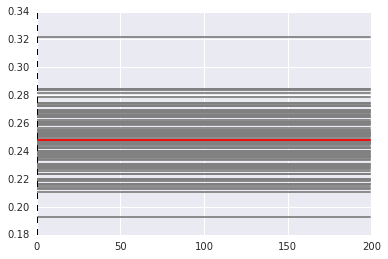

In [311]:
prob_t_given_x = np.mean(posteriors,axis=0)

for posterior in posteriors:
    plt.plot(posterior, color="grey")
    
plt.plot(prob_t_given_x, color="red")
plt.axvline(np.argmax(prob_t_given_x), 
            color="black", 
            linestyle='dashed',
            linewidth=2)

#### Recall sum of independent gaussians i a Gaussian 

- **A sum of independent (multivariate) Gaussians is (multivariate) Gaussian, with mean equal to the sum of the means, and covariance equal to the sum of the covariances.**

therefore:

- Given $N$ Gaussians defined with $(\mu_1,\sigma^2_1), \dots, (\mu_N,\sigma^2_N)$ the sum of gaussians is a gaussian with $\mu= \sum_{n=1}^N \mu_n$ and  $\sigma = \sum_{n=1}^N \sigma_n$

In [213]:
prob_t_given_x = np.mean(posteriors,axis=0)

In [205]:
prob_t_given_x.mean()

0.12303439185547656

In [195]:
np.array(posteriors[1]).shape

(200, 1)

In [197]:
prob_t_given_x [100]

array([ 0.24728342])

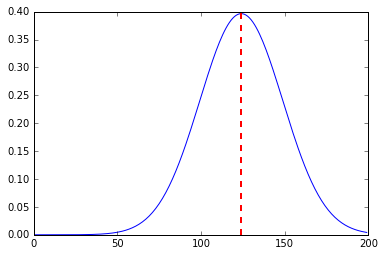

In [223]:
plt.plot(prob_t_given_x)
plt.axvline(np.argmax(prob_t_given_x), 
            color="red", 
            linestyle='dashed',
            linewidth=2)

## Learning the same data using a MLP

### Using find_MAP

In [334]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm

X_train = X.reshape(len(X),1)
Y_train = Y

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, output_dim)
init_b2 = np.random.randn(output_dim )

In [335]:
mlp = pymc3.Model()

with mlp:
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_0_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_1', 0, sd=1, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden,1 ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_2', 0, sd=1, 
                           shape= (output_dim,), 
                           testval=init_b2)
    
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.dot(act_1, weights_1_out) + bias_in_2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=act_out, observed=ann_output )
    #Y_obs = Normal('Y_obs', mu=act_out, sd=sigma, observed=ann_output)

Applied log-transform to sigma and added transformed sigma_log_ to model.


In [336]:
with mlp:
    # Inference!
    start = pymc3.find_MAP() # Find starting value by optimization
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(200, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

 [-----------------100%-----------------] 200 of 200 complete in 253.0 sec

In [337]:
trace

<MultiTrace: 1 chains, 200 iterations, 6 variables>

In [338]:
mu_params

{'b_1': array([-1.03698313, -1.75303267, -1.40772628]),
 'b_2': array([ 0.91755864]),
 'sigma_log_': array(1.8085192723878076),
 'w_0_1': array([[ 0.01439613,  0.00627643,  0.00135914]]),
 'w_1_2': array([[-0.00173971],
        [ 0.00359032],
        [-0.00531535]])}

In [339]:
sds_params

{'b_1': array([ 0.60789399,  0.95192213,  0.74356073]),
 'b_2': array([ 0.16392472]),
 'sigma_log_': 1.6160920845222355,
 'w_0_1': array([[ 0.18706233,  0.17145043,  0.17812802]]),
 'w_1_2': array([[ 0.22876458],
        [ 0.15125377],
        [ 0.20315062]])}

In [340]:
trace["w_1_2"].shape

(200, 3, 1)

#### Looking at the trace 

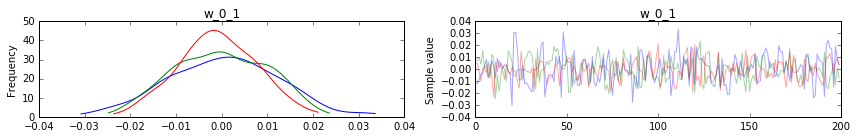

In [341]:
pm.traceplot(trace, ["w_0_1"]);

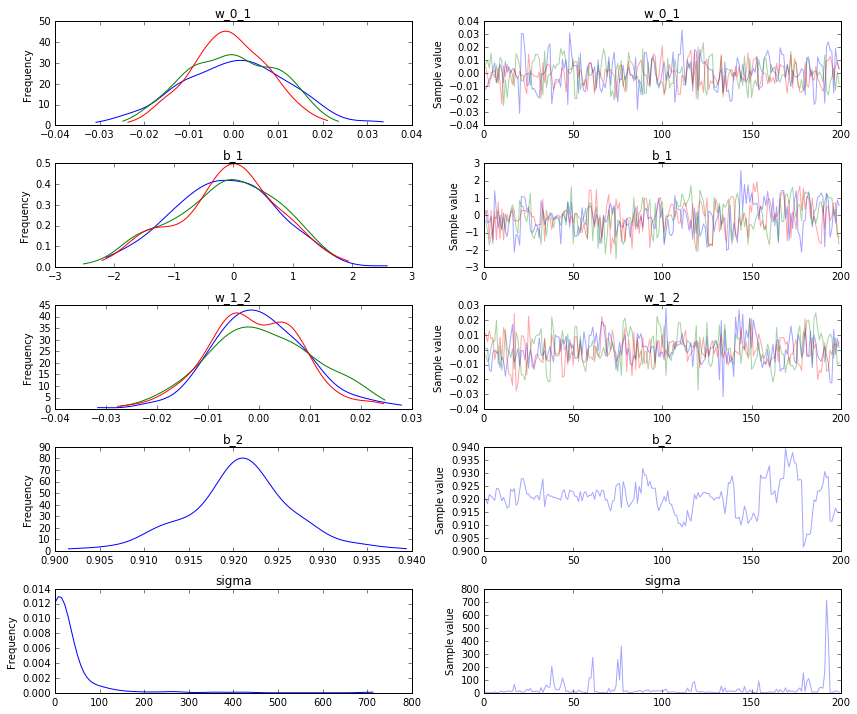

In [342]:
pm.traceplot(trace);

## solution plot

Now lets us:

- Take the learned weights and put them in the MLP object
- Make predictions using the mean value across the samples


In [343]:
trace["w_0_1"].shape

(200, 1, 3)

In [344]:
trace["w_0_1"].mean(axis=0).shape

(1, 3)

In [345]:
trace["w_0_1"].mean(axis=0)

array([[ 0.00045123, -0.00023542, -0.00087786]])

In [346]:
X_train = X.reshape(len(X),1)
Y_train = Y

sym_input = T.dmatrix("sym_input")

# Defined shared variables of the model
sha_W1 = theano.shared(trace["w_0_1"].mean(axis=0))
sha_b1 = theano.shared(trace["b_1"].mean(axis=0))
sha_W2 = theano.shared(trace["w_1_2"].mean(axis=0))
sha_b2 = theano.shared(trace["b_2"].mean(axis=0))

act_1 = T.nnet.relu( T.dot(sym_input, sha_W1) + sha_b1)
act_out = T.dot(act_1, sha_W2) + sha_b2
predict = theano.function([sym_input],act_out)

In [348]:
x1_grid.shape

(200,)

In [349]:
predictions = predict(x1_grid.reshape(len(x1_grid),1))

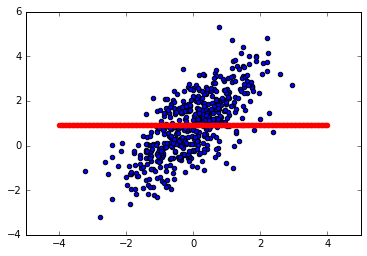

In [350]:
%matplotlib inline

## plot data
plt.scatter(X, Y)

# Write 
plt.scatter(x1_grid,
            predictions,
                color="r")

## Sinusoidal data

In [ ]:
X, Y  = generate_1dsinusoidal_data(num_samples=500, seed_val = 123)

## Modelling without mp.sample

In [ ]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm
import numpy as np

X_train = np.vstack((X1,X2)).T
Y_train = Y

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

In [ ]:
std_val = 0.01
n_hidden = 3
input_dim = 2
output_dim = 1

In [ ]:
# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, output_dim)
init_b2 = np.random.randn(output_dim )

In [ ]:
mlp = pymc3.Model()

with mlp:
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_in_1', 0, sd=1, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden,1 ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_in_2', 0, sd=1, 
                           shape= (output_dim,), 
                           testval=init_b2)
    
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.dot(act_1, weights_1_out) + bias_in_2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=act_out, observed=ann_output )
    #Y_obs = Normal('Y_obs', mu=act_out, sd=sigma, observed=ann_output)

In [ ]:
with mlp:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=10000)

In [ ]:
plt.plot(v_params.elbo_vals)

In [ ]:
v_params.elbo_vals.max()

In [ ]:
v_params.__dict__

In [ ]:
v_params[0]

In [ ]:
help(pm.variational)

About the evidence lower bounds

- https://benmoran.wordpress.com/2015/02/21/variational-bayes-and-the-evidence-lower-bound/

### Can't we sample? Sure but it's slow...

In [ ]:
with mlp:
    start = pymc3.find_MAP() # Find starting value by optimization
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(100, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

## Fix parameters of the model and make predictions

### A little theano example

In [ ]:
sym_x = T.dmatrix('x')
s = 1 / (1 + T.exp(-sym_x))
logistic = theano.function([sym_x], s)

In [ ]:
logistic([[0, 1], [-1, -2]])

In [ ]:
sym_input = theano.tensor.matrix("sym_input")

np.random.seed(123)
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

sha_W1 = theano.shared(init_w1)
sha_b1 = theano.shared(init_b1)

first_layer_act = T.nnet.relu(T.dot(sym_input , sha_W1 ) + sha_b1 )
acti = theano.function([sym_input],first_layer_act)

In [ ]:
acti(np.array([[23],[23]],dtype="float32"))